In [232]:
## Loading package
# 过滤掉所有警告
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from utils import mclust_R
from model import DCCAE
from preprocess import preprocessing
from preprocess import fix_seed
import numpy as np


adata_modality_1 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/adata_ADT.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

In [233]:
fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'Stereo-CITE-seq')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

Stereo-CITE-seq data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (4183, 3000)
Dimensions after preprocessing adata_modal_2: (4183, 19)


In [234]:
# 19, 10, 100
# 19, 10, 150
# 19, 10, 120
n_output = 19
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca'].copy()
Y = adata_modality_2.obsm['X_pca'].copy()

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCAE = 8
epochs = 150
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCAE, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress: 100%|██████████| 150/150 [00:30<00:00,  4.90it/s]

model training finished!


In [235]:
use_rep = ['DCCAE_X', 'DCCAE_Y', 'DCCAE']
mclust_R(adata_modality_1, used_obsm=use_rep[2], num_cluster=7)

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4183 × 3000
    obs: 'orig.ident', 'x', 'y', 'n_genes', 'clusters_mclust'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'INR', 'hvg', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'DCCAE_X', 'DCCAE'
    varm: 'PCs'

In [191]:
# 切片需要顺时针旋转90度
coordinates = adata_modality_1.obsm['spatial']

# 旋转90度（顺时针）
rotated_coordinates = np.zeros_like(coordinates)  # 创建一个同样形状的数组用于存放旋转后的坐标
rotated_coordinates[:, 0] = -coordinates[:, 1]  # 新的x坐标是原始的y坐标取反
rotated_coordinates[:, 1] = coordinates[:, 0]  # 新的y坐标是原始的x坐标

adata_modality_1.obsm['spatial'] = rotated_coordinates

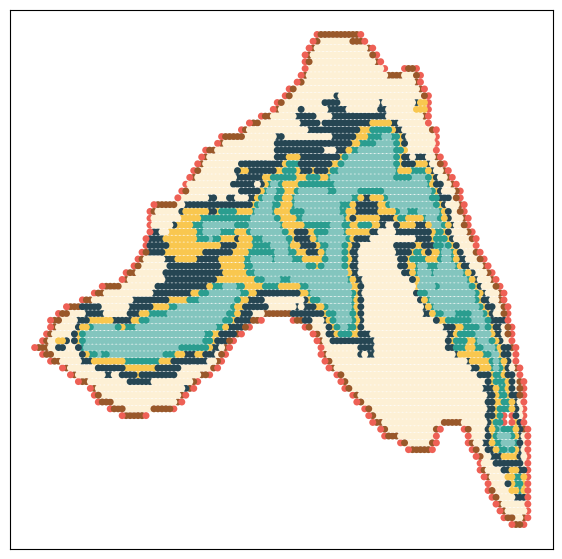

In [236]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
# colors = [
#     '#264653', '#fdf0d5', '#83c5be',  '#f9c74f', '#99582a', '#ee6055', '#2a9d8f'
# ]

# colors = [
#     '#ee6055', '#fdf0d5', '#99582a',  '#2a9d8f', '#f9c74f', '#83c5be', '#264653'
# ]

# colors = [
#     '#ee6055', '#f9c74f', '#83c5be',  '#fdf0d5', '#99582a', '#2a9d8f', '#264653'
# ]
sc.pl.embedding(adata_modality_1, basis='spatial', color='clusters_mclust', ax=ax, s=100, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
# remove legend
ax.get_legend().remove()

In [237]:
## obs store the clustering results
## uns store the integrated embeddings
# adata_SpaKnit = anndata.AnnData()
adata_SpaKnit = anndata.AnnData()
adata_SpaKnit.obs['SpaKnit'] = adata_modality_1.obs['clusters_mclust']
adata_SpaKnit.obsm['SpaKnit'] = adata_modality_1.obsm['DCCAE']
adata_SpaKnit.obsm['spatial'] = adata_modality_1.obsm['spatial']
adata_SpaKnit.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Thymus_Replicate1.h5ad')

In [230]:
adata_SpaKnit

AnnData object with n_obs × n_vars = 4573 × 0
    obs: 'SpaKnit'
    obsm: 'SpaKnit', 'spatial'

In [238]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_mclust')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_mclust', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/Replicate1/" + 'Replicate1_marker_genes.xlsx', index=True)